In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

In [5]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

### Simple repression

In [6]:
# LacI binding site
rep_site = 'AATTGTGAGCGGATAACAATT'

In [7]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [8]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

In [9]:
n_NS = len(genome)
n_p = 5000
l_n_r = np.arange(1, 5000, 5)
ep_wt = -7
l_er_wt = [-10, -12, -15]

dr = []
for er_wt in l_er_wt:
    dr_simrep = []
    for n_r in l_n_r:
        df = tregs.simulate.sim_pointmut(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site],
                                        [rep_site],
                                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                        scaling_factor=10*6)

        norm_ct = df['norm_ct_1'].to_numpy()
        dr_simrep.append(np.mean(norm_ct[1:] - norm_ct[0]))
    dr.append(dr_simrep)

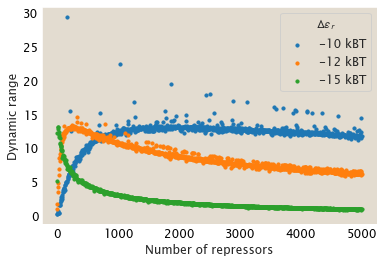

In [10]:
fig, ax = plt.subplots()
for i in range(3):
    ax.scatter(l_n_r, dr[i], label='{} kBT'.format(str(l_er_wt[i])), s=10)
ax.set_xlabel('Number of repressors')
ax.set_ylabel('Dynamic range')
ax.legend(title=r'$\Delta \epsilon_{r}$')

### Double repression

In [11]:
rep1_site = promoter[(115-70):(115-60)]
rep2_site = promoter[(115-50):(115-40)]
r1_emat = tregs.simulate.generate_emap(rep1_site, fixed=True, fixed_value=1)
r2_emat = tregs.simulate.generate_emap(rep2_site, fixed=True, fixed_value=1)

In [12]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -7, -10, -10
n_p, n_r2 = 5000, 15
l_n_r1 = np.arange(0, 100, 1)
l_e_int = [-5, -7, -10]

dr_doublerep = []
for e_int in l_e_int:
    dr_doublerep_AND = []
    for n_r1 in l_n_r1:
        df = tregs.simulate.sim_pointmut(promoter, tregs.simulate.doublerep_pbound, [rnap_site, rep1_site, rep2_site],
                            [rep1_site, rep2_site],
                            *[n_NS, n_p, n_r1, n_r2, rnap_emat, r1_emat, r2_emat, ep_wt, er1_wt, er2_wt, e_int, 'AND'],
                            scaling_factor=10**4)

        norm_ct = df['norm_ct_1'].to_numpy()
        dr_doublerep_AND.append(np.mean(norm_ct[1:] - norm_ct[0]))
    dr_doublerep.append(dr_doublerep_AND)

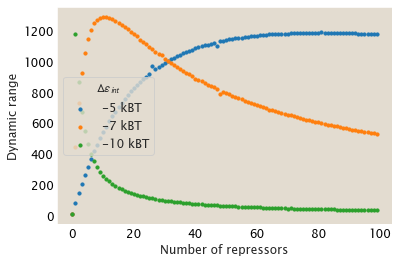

In [13]:
fig, ax = plt.subplots()
for i in range(3):
    ax.scatter(l_n_r1, dr_doublerep[i], label='{} kBT'.format(str(l_e_int[i])), s=10)
ax.set_xlabel('Number of repressors')
ax.set_ylabel('Dynamic range')
ax.legend(title=r'$\Delta \epsilon_{int}$')

### Simple activation

In [14]:
# CRP binding site
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'

In [15]:
# energy matrix obtained from Fig 3. of Kinney et al., 2010 (https://www.pnas.org/doi/full/10.1073/pnas.1004290107)
# elements expressed in kcal/mol (1 kcal/mol = 1.62kbT)

crp_emat_raw = pd.read_table('../../data/energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy().T * 1.62

In [16]:
n_NS = len(genome)
n_p = 5000
l_n_a = np.arange(1, 1000, 5)
ep_wt = -7
l_ea_wt = [-10, -12, -15]
e_ap = -10

dr_simact = []
for ea_wt in l_ea_wt:
    dr = []
    for n_a in l_n_a:
        df = tregs.simulate.sim_pointmut(promoter, tregs.simulate.simact_pbound, [rnap_site, crp_site],
                                         [crp_site],
                                         *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap],scaling_factor=10**6)

        norm_ct = df['norm_ct_1'].to_numpy()
        dr.append(np.mean(norm_ct[1:] - norm_ct[0]))
    dr_simact.append(dr)

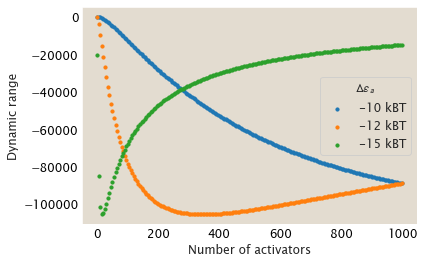

In [17]:
fig, ax = plt.subplots()
for i in range(3):
    ax.scatter(l_n_a, dr_simact[i], label='{} kBT'.format(str(l_ea_wt[i])), s=10)
ax.set_xlabel('Number of activators')
ax.set_ylabel('Dynamic range')
ax.legend(title=r'$\Delta \epsilon_{a}$')

### Double activation

In [18]:
act1_site = promoter[(115 - 110 + 15):(115 - 110 + 25)]
act2_site = promoter[(115 - 110 + 35):(115 - 110 + 45)]
a1_emat = tregs.simulate.generate_emap(act1_site, fixed=True, fixed_value=1)
a2_emat = tregs.simulate.generate_emap(act2_site, fixed=True, fixed_value=1)

In [28]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
l_e_int_pa1 = [-3, -5, -7, -9]
e_int_a1a2 = -5
n_p, n_a2 = 4600, 50
l_n_a1 = np.arange(0, 1000, 1)

dr_doubleact_AND = []
for e_int_pa1 in l_e_int_pa1:
    e_int_pa2 = e_int_pa1
    dr = []
    for n_a1 in l_n_a1:
        df = tregs.simulate.sim_pointmut(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                            [act1_site, act2_site],
                            *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'AND'], scaling_factor=10**4)
        norm_ct = df['norm_ct_1'].to_numpy()
        dr.append(np.mean(norm_ct[1:] - norm_ct[0]))
    dr_doubleact_AND.append(dr)

In [29]:
dr_doubleact_OR = []
for e_int_pa1 in l_e_int_pa1:
    e_int_pa2 = e_int_pa1
    dr = []
    for n_a1 in l_n_a1:
        df = tregs.simulate.sim_pointmut(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        [act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'OR'], scaling_factor=10**4)
        norm_ct = df['norm_ct_1'].to_numpy()
        dr.append(np.mean(norm_ct[1:] - norm_ct[0]))
    dr_doubleact_OR.append(dr)

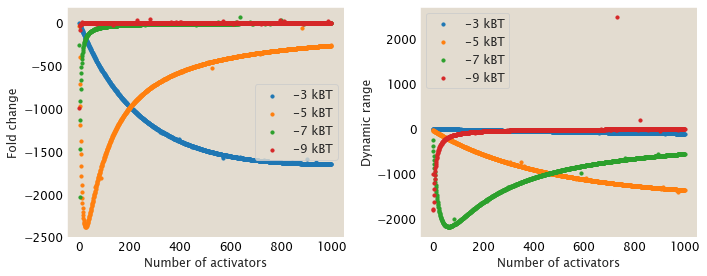

In [30]:
# plot fold change and dynamic range against number of activators
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes

for i in range(4):
    ax1.scatter(l_n_a1, dr_doubleact_AND[i], label='{} kBT'.format(str(l_e_int_pa1[i])), s=10)
    ax2.scatter(l_n_a1, dr_doubleact_OR[i], label='{} kBT'.format(str(l_e_int_pa1[i])), s=10)

ax1.set_xlabel('Number of activators')
ax1.set_ylabel('Fold change')
ax1.legend()

ax2.set_xlabel('Number of activators')
ax2.set_ylabel('Dynamic range')
ax2.legend()

plt.tight_layout()

### Changing interaction energy

In [31]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2 = -4, -4
n_p, n_a1, n_a2 = 4600, 50, 50
l_e_int_a1a2 = np.arange(-20, 10, 1)

dr_doubleact_AND2 = []
for e_int_a1a2 in l_e_int_a1a2:
    df = tregs.simulate.sim_pointmut(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        [act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'AND'], scaling_factor=10**6)

    norm_ct = df['norm_ct_1'].to_numpy()
    dr_doubleact_AND2.append(np.mean(norm_ct[1:] - norm_ct[0]))

In [32]:
fc_doubleact_OR2 = []
dr_doubleact_OR2 = []
wt_doubleact_OR2 = []
mut_doubleact_OR2 = []
for e_int_a1a2 in l_e_int_a1a2:
    df = tregs.simulate.sim_pointmut(promoter, tregs.simulate.doubleact_pbound, [rnap_site, act1_site, act2_site],
                        [act1_site, act2_site],
                        *[n_NS, n_p, n_a1, n_a2, rnap_emat, a1_emat, a2_emat, ep_wt, ea1_wt, ea2_wt, e_int_a1a2, e_int_pa1, e_int_pa2, 'OR'], scaling_factor=10**6)
    norm_ct = df['norm_ct_1'].to_numpy()
    fc = np.mean(norm_ct[1:] / norm_ct[0])
    fc_doubleact_OR2.append(fc)
    dr_doubleact_OR2.append(np.max(norm_ct) - np.min(norm_ct))
    wt_doubleact_OR2.append(norm_ct[0])
    mut_doubleact_OR2.append(np.mean(norm_ct[1:]))

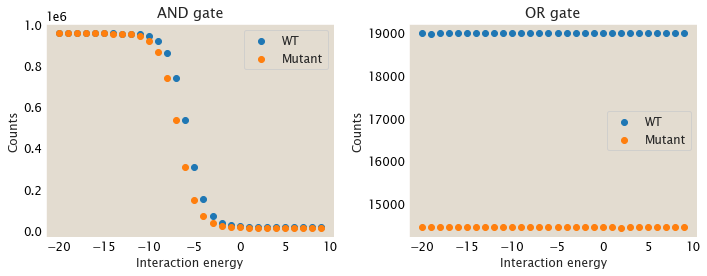

In [33]:
# plot wild type and mutant counts against interaction energy
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes

ax1.scatter(l_e_int_a1a2, wt_doubleact_AND2, label='WT')
ax1.scatter(l_e_int_a1a2, mut_doubleact_AND2, label='Mutant')
ax1.set_xlabel('Interaction energy')
ax1.set_ylabel('Counts')
ax1.set_title('AND gate')
ax1.legend()

ax2.scatter(l_e_int_a1a2, wt_doubleact_OR2, label='WT')
ax2.scatter(l_e_int_a1a2, mut_doubleact_OR2, label='Mutant')
ax2.set_xlabel('Interaction energy')
ax2.set_ylabel('Counts')
ax2.set_title('OR gate')
ax2.legend()

plt.tight_layout()

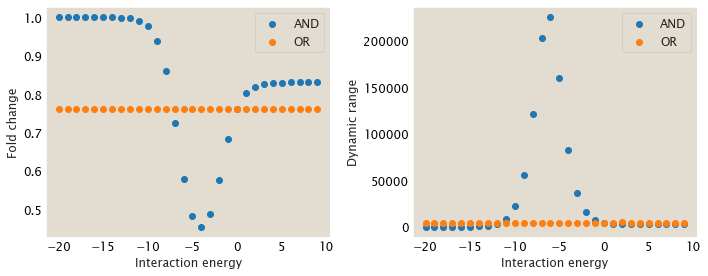

In [34]:
# plot fold change and dynamic range against interaction energy
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax1, ax2 = axes

ax1.scatter(l_e_int_a1a2, fc_doubleact_AND2, label='AND')
ax1.scatter(l_e_int_a1a2, fc_doubleact_OR2, label='OR')
ax1.set_xlabel('Interaction energy')
ax1.set_ylabel('Fold change')
ax1.legend()

ax2.scatter(l_e_int_a1a2, dr_doubleact_AND2, label='AND')
ax2.scatter(l_e_int_a1a2, dr_doubleact_OR2, label='OR')
ax2.set_xlabel('Interaction energy')
ax2.set_ylabel('Dynamic range')
ax2.legend()

plt.tight_layout()